In [ ]:
#default_exp seg_dataset_isri_unlv

# ISRI UNLV

> [image] -> [segmentation maps]

download dataset from https://code.google.com/archive/p/isri-ocr-evaluation-tools/  
dir structure: 
`
./data/isri_unlv/
    | bus.2B
        | 0/
            | ...2B.tif
            | ...2B.txt
            | ...2B.uzn
            ...
        | 1/
        ...
    ...
`

In [ ]:
#export
from ocr.core import save_dict, read_dict, plot
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pathlib import PosixPath

In [ ]:
#export
cat2id = {
'Background': 0,
'Attent_line': 1,
'Other_Text': 2,
'cc': 3,
'Company_Sig': 4,
'Subject': 5,
'Enclosure': 6,
'Sign/Type': 7,
'Inside_Addr': 8,
'Dateline': 9,
'Footnote': 10,
'Closing': 10,
'Salutat': 11,
'Signer': 12,
'Letterhead': 13,
'Table': 14,
'Caption': 15,
'Header/Footer': 16,
'Text': 17
}

class isri_unlv_config:
    MAIN_DIR = PosixPath('../data/isri_unlv/')
    SEG_DIR = PosixPath('../data/seg/labels/')
    IMG_DIR = PosixPath('../data/seg/images/')
    cat2id = cat2id

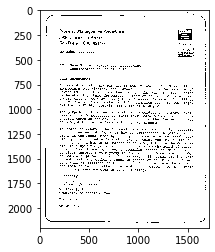

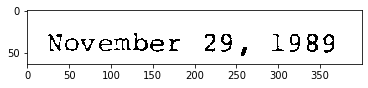

In [ ]:
im = cv2.imread(str(isri_unlv_config.MAIN_DIR/'bus.2B'/'0'/'8500_001.2B.tif'))
plot(im)
l,t,w,h,cat = [177, 381, 400, 64, 'Dateline']
plot(im[t:t+h , l:l+w])

In [ ]:
cat_freq = {
'Attent_line': 8,
'Other_Text': 28,
'cc': 31,
'Company_Sig': 32,
'Subject': 51,
'Enclosure': 116,
'Sign/Type': 259,
'Inside_Addr': 361,
'Dateline': 514,
'Footnote': 615,
'Closing': 634,
'Salutat': 654,
'Signer': 761,
'Letterhead': 1365,
'Table': 1668,
'Caption': 3453,
'Header/Footer': 6723,
'Text': 24762
}

In [ ]:
cats = ['Background', 'Attent_line', 'Other_Text', 'cc', 'Company_Sig', 'Subject', 'Enclosure', 'Sign/Type', 'Inside_Addr', 'Dateline', 'Footnote', 'Closing', 'Salutat', 'Signer', 'Letterhead', 'Table', 'Caption', 'Header/Footer', 'Text']
cat2id = {c:i for i,c in enumerate(cats)}

In [ ]:
read = lambda fp: open(fp).read()
read_lines = lambda fp: open(fp).readlines()

cat_freq = defaultdict(lambda: 0)
doc2paths = defaultdict(lambda: {'img': None, 'txt': None, 'uzn': None})
for fp in isri_unlv_config.MAIN_DIR.iterdir():
    if str(fp)[-1] == 'B' or str(fp)[-1] == 'A':
        document_category = str(fp).split('/')[-1]
        for subfp in fp.iterdir():
            if os.path.isdir(subfp):
                page_id = str(subfp).split('/')[-1]
                for i,fpath in enumerate(subfp.iterdir()):
                    doc_name = str(fpath).split('/')[-1][:-4]
                    fn = 'isri_unlv_{}_{}'.format(document_category, page_id, i)
                    if str(fpath)[-4:] == '.tif':
                        doc2paths[doc_name]['img'] = fpath

                    if str(fpath)[-4:] == '.txt':
                        doc2paths[doc_name]['txt'] = fpath
                    
                    if str(fpath)[-4:] == '.uzn':
                        doc2paths[doc_name]['uzn'] = fpath
doc2paths = dict(doc2paths)
del doc2paths['total']

In [ ]:
for name in doc2paths.keys():
    x = doc2paths[name]
    if x['uzn'] is None or  x['img'] is None or  x['txt'] is None:
        raise Exception('wtf', name)

In [ ]:
def preprocess_category(cstr): # category string -> id int
    return cat2id[cstr] if cstr in cat2id else cat2id['Background']

In [ ]:
read = lambda fp: open(fp).read()
read_lines = lambda fp: open(fp).readlines()

cat_freq = defaultdict(lambda: 0)
for i, name in enumerate(progress_bar(doc2paths.keys())):
    fn = 'isri_unlv_{}'.format(i)
    uzn_path = doc2paths[name]['uzn']
    img_path = doc2paths[name]['img']
    txt_path = doc2paths[name]['txt']
    # img
    im = cv2.imread(str(img_path))
    cv2.imwrite(str(isri_unlv_config.IMG_DIR/(fn+'.png')), im)
    # seg
    seg = np.zeros(im.shape[:2] + (1,), dtype=int) + cat2id['Background']
    for line in read_lines(uzn_path):
        try: l,t,w,h,cat = [w for w in line.split(' ') if w != '']
        except: continue # there are some `  ` (double space) lines
        cat = cat[:-1]
        cat_freq[cat] += 1
        cat_id = preprocess_category(cat)
        l,t,w,h = map(int, [l,t,w,h])
        seg[ t:t+h , l:l+w ] = cat_id
    seg = ImageSegment(tensor(seg).permute(2,0,1))
    seg.save(str(isri_unlv_config.SEG_DIR/(fn+'.png')))
    # txt
    # ...

In [ ]:
cat_freq = dict(sorted(cat_freq.items(), key=lambda k:k[1]))
cat_freq

{'Attent_line': 8,
 'Other_Text': 28,
 'cc': 31,
 'Company_Sig': 32,
 'Subject': 51,
 'Enclosure': 116,
 'Sign/Type': 259,
 'Inside_Addr': 361,
 'Dateline': 514,
 'Footnote': 615,
 'Closing': 634,
 'Salutat': 654,
 'Signer': 761,
 'Letterhead': 1365,
 'Table': 1668,
 'Caption': 3453,
 'Header/Footer': 6723,
 'Text': 24762}